# Design of a 6th order finite difference Poisson solver

# A. Motivation: bounded domains

Previously, we have provided a prescription to optimize a deterministic semi-Lagrangian strategem (convected scheme, CS) apt for the solution to the parabolic partial differential equation 

$$\partial_t g + k\partial_z g = 0, \qquad \qquad k\in\mathbb{R}, g = g(t,z)$$ 

to arbitrary order correctness. This procedure requires adding correction terms to incremental updates which in part depend on the accurate computation of $N-1$ derivatives of the state function $g$ to achieve a solution with a local truncation error (LTE) of order $N+1$. 

For non-open (closed or semi-open) systems, the boundaries break the periodicity and force our hand to consider alternate forms of computing the derivatives, the most obvious candidate being finite difference schemes. In a previous notebook ("Generation of families of explicit finite difference schemes for derivatives of any order of chosen LTE"), a series of scripts were developed to compute explicit finite difference coefficient tables for the family of schemes for any derivative for user queried LTEs. These files can be read in and stored as a matrix which produces the derivative of the post-multiplied function that can be efficiently accomplished as a vectorized operation using NumPy arrays. Efforts were made to follow the maxim for the differencing to remain "as centered as reasonably achievable" (ACARA, H/T to the radiation dosimetry mnemonic, 'ALARA'), a principle that permits grid sampling for FD computations in the interior to be the most-centered scheme available whereas near the edge nodes the construction of the matrix employs schemes only with as much deviation from centered as is required to stay within the domain (see the aformentioned notebook for details). 

In the notebook <a href = "../DECSKS-03%20--%20Convergence%20of%20FD%20formulation%20of%20high%20order%20CS/DECSKS-03%20--Convergence%20of%20FD%20formulation%20of%20high%20order%20CS.ipynb">Convergence of FD formulation of high order CS</a>, it was shown for a test density that we can correct CS solutions to advection equations up to order $O(\Delta z^{10})$. Recall, trying to pursue higher order is not achievable where the source of this problem was convincingly demonstrated to be an effect of the many FD derivatives required beyond this order failed to simultaneously converge for a given mesh (one or more fall into non-convergent zones, so the requisite LTE is not achieved). Thus, we note our provisional limit in the phase space remapping assignment is perhaps LTE order $O(\Delta z^{10})$, $z = \{x,v\}$.  

When addressing more involved physics (e.g. Vlasov, just below), the accuracy of our solution will <i>not</i> be controlled by the order of the CS solver incidentally, but ultimately by the choice of what is ultimately an expensive and lower order time splitting scheme used in the numerical stepthrough (e.g. time splitting schemes of LTE orders 3, 5, 7 are within the means of serial processing; however, pushing for more accurate schemes is both too intensive at this juncture, and it is unclear what a motivating context or test problem would need higher order), so we are not discouraged in the slightest. What we desire is a phase space remapping of an order $O(\Delta z^{N+1})$ LTE that is high enough to not further pollute the solution with respect to the limitations of the time splitting procedure, which scales with LTEs of order $O(\Delta t^3)$, $O(\Delta t^5)$, $O(\Delta t^7)$, $\ldots$. Since the CFL numbers are not constant, there is no obvious relationship between the mesh spacing $\Delta z$ and the time grid spacing $\Delta t$. 

<i>(We also point out to the reader that we never say "order" on its own as this is ambiguous and language is used both undiligently and inconsistently in literature (whether an "order $N$" method means "correct up to order $N$" (LTE order = $N+1$), or if someone means an "order $N$" method means the LTE is order $N$). Note, that we always say "LTE order" or "global error of order," or some variation in order to specify what it is we are speaking of. In this way, the point of bringing this to the reader's attention is that time splitting literature tends to favor labelling methods as $N$th order if they have an LTE of $N+1$ (i.e. the method is termed with the notion that it is correct <i>up to and including order $N$</i>), which is opposite to the preference in most PDE solver literature (an $N$th order method means the LTE itself is of order $N$, i.e. is correct <i>up to and including order $N-1$</i>). In this way, for the popular time splitting leapfrog scheme, it is often abbreviated as LF2, with mention that it is 2nd order, but this means its LTE is order 3. This is the opposite of how we speak of PDE solvers, e.g. a solver being of "order" 3 means the LTE is of order 3 in most publishings. Thus, it should be understood there is no conflict with the above LTEs reported for time splitting, e.g. Yoshida 4, aka Y4, has an LTE order of 5, because the convention used in its definition is just incompatible with the PDE solver literature norm. In order to not rely on the reader to "know" this common confusion, we make note that we will always specify LTE or GE (global error) when talking of "order."</i>

Moving on from an advection equation, we incorporate an acceleration term $a = a(t,x)$. In a plasma context we first consider only electrostatic interactions for cold ions (uniform background $n_0$ defined according to quasineutrality such that $n_e = n_0$) so that $a \sim E(t,x) = -\partial_x \phi(t,x)$. Hence, we consider the <i>Vlasov-Poisson system</i>:

$$\partial_t f + v\partial_x f + (\partial_x\phi) \partial_v f = 0$$
$${}$$
$$\partial_x^2 \phi = \int_v dv f(t,x,v) - n_0$$

Note, the units have been normalized (see dsirajud/Preliminary-Examination for details) and we take the case of hyrogenic atoms so that the charges are equal but opposite. At this juncture we do not address collisions but instead include only details pertaining to energy exchanges with the field and field particles. For periodic systems, we have benchmarked CS solutions against a two-stream instability and Landau damping test cases that show agreement among several solvers (DG, Eulerian, ...). The above equation can be solved numerically by time-splitting schemes (e.g. leapfrog).

For closed systems, <b>we consider CS at least at an LTE of order 6 given at best we aim to use an RKN time splitting scheme with an LTE of 7 (e.g. O11-6). Thus, in order to retain an LTE overall of order 6, we require a Poisson solver to have an LTE order of 6.</b> The subsequent excursions using these tools will likely investigate lower order time splitters as well (LF2, Y4, O6-4), which is of no further potential consequence from the CS solver or the Poisson solver provided we meet this minimum requirement of order 6. 

# B. Setup

## B.1. Motivation for Poisson vs. Gauss solver:

It is inviting to consider Gauss' law instead of Poisson's equation:

$$\partial_x E = n_i - n_e$$

The author was in fact very cordially invited by this temptation, in order to fuss with one order of derivative less; however, it was found after much convincing (and time spent) that there is not a way to make a 6th order scheme that produces a unique solution. In other words, the assembled matrix system for the above problem, no matter the choice of finite differences:

$$\underline{\underline{D}} \underline{E} = \underline{N}, \qquad \qquad \underline{N} = \underline{n}_i - \underline{n}_e$$

The matrix $\underline{\underline{D}}$ is always singular in the author's experience, in other words ostensibly no such matrix can be found that is diagonally dominant, or it can be said and shown in every such case that $D^{-1}$ does not exist. Humbly, the author notes this is probably why Poisson solvers are so often the topic of interest without any mention of Gauss law solvers for the equivalent plasma physics context (though does note at least one exception that Gauss solvers find footing in finite different solvers using Yee cells). As will be seen below, a Poisson solver can be designed with an appropriate coefficient matrix which produces unique solutions.

## B.2. Poisson's equation and grid

We consider the 1D elliptic equation:

$$\partial_x^2\phi = n_e - n_0, \qquad x\in [a,b], \qquad \phi = \phi(t,x)$$

where

$$n_e = n_e(t,x) = \int_v dv f_{\alpha}(t,x,v)$$

The scalar function $\phi = \phi (t,x)$is called the electric potential, whose definition is permitted by restricting the Maxwell equations to cases where the magnetic field is not involved. For our immediate plasma context, we define an electron density, $n_e = n_e(t,x)$ and a constant positive ion density $n_0$ (cold background); the constants $a$ and $b$ are arbitrary. The derivation in section C deal with this case to emphasize the details of the method without encumbering the process with extra terms, the result for non-constant ion density is obtained in exactly the same way as shown below, and the result is quoted for convenience, though the details are saved for the reader as the details only differ by a sign.

We approximate the continuous functions with grid functions whose cell-centered values correspond to each $x = x_i$, for $i = 0, 1, \ldots , N-1$, where Pythonic indexing is used, and we will define the domain as $x_0 = a$, $x_{N-1} = b$, with uniform spacing $\Delta x = L / (N_x - 1)$ for $N_x$ grid points over the domain of size $L = b - a$.

# C. Derivation of scheme: Dirichlet boundary conditions

## C.1. Strategy

The idea is to analytically derive high order estimations of $\partial_x^2 \phi (x_i)$ (we suppress the time dependence for brevity) whose finite difference operators sample only points on the grid (we evade employing ghost points to retain a general scheme). The solution to the set of $N$ equations provides the solution to $\phi$ for all $x_i$, $i = 0, 1, \ldots , N-1$ to $O(\Delta x^6)$.

The finite derivative estimates of $\partial_x^2\phi$ are obtained by straightforward Taylor expansion at a grid point $x_{i + k}, \, k\in\mathbb{Z}$ which necessarily incur a local truncation order that scales with $O(\Delta x^M)$. This FD estimate was obtained by considering <i>one</i> grid point $x_{i+k}$. In any case, this will yield an LTE that scales with $O(\Delta x^2)$. In order to make the FD estimate higher order, two options are available here:

<ol>
<li> <u>If there is no PDE</u>: and we consider the pure math problem of raising the LTE of the second derivative then the only manner in which the FD estimate of $\partial_x^2\phi (x_i)$ can be increased to higher order is by considering expanding $\phi (t, x_{i + k})$ for several other $k\in\mathbb{Z}$. Doing so, we develop a set of equations, that upon manipulation we have the latitude needed to eliminate orders by Gaussian elimination. This can be repeated for more points, and the algebra can be done so that higher and higher orders are killed off so that we achieve an overall highier LTE. Necessarily, this expands the stencil $\{k\}$ of the FD scheme. Such schemes are called explicit. Alternatively, the same result is obtained in recognition that linear combination of derivatives (expressed in terms of differences among the $\{\phi (x_{i+k})\}$ is ultimately what cancels high order terms. So, rather than astutely manipulate the equations as needed, instead the equivalent problem can be cast as an undetermined coefficients problem 

$$\sum_k c_k \phi(x_{i+k}) = O(\Delta x^M)$$

for a desired order $M$ (e.g. $M = 6$). In this way, we Taylor expand the left-hand sides after this statement has already been assembled, and construct order requirements that each order up to but not including the order $M$ vanish. This produces enough equations to solve for the equations uniquely in the explicit case. A second suboption here is to instead not put all the burden on the function $\phi$ itself at several grid points, but instead to put weights on the derivative itself 

$$a\phi '' (x_{i-1}) + b\phi '' (x_i) + c\phi '' (x_{i+1}) = e\phi (x_{i-1}) + h\phi (x_i) + \ell\phi(x_{i+1})$$ 

so we expand the right-hand side, and arrive at a set of coupled (on $\phi ''$) order conditions that require the orders $n < M$ vanish accordingly. Such schemes are hence <i>implicit</i>, and do not generally have unique solutions, but families of solutions by judicious choices of one coefficients ($a, b, c, e, h, \ell$) which give rise to well-known schemes such as the Padé scheme. Implicit schemes are computational more expensive than explicit, hence we do not consider this at the juncture, though later investigations may provide motivation to return to this issue given restricting the stencil size is a admittedly desirable. Hence, implicit schemes are often called <i>compact</i> because of their potential to restrict the stencil size as compared to explicit schemes.
$${}$$

<li> <u>If there <i>is</i> a PDE</u>: Rather than resorting to consider increasingly more grid points, we exploit the hand we are given by relating the derivative of $\phi$ appearing in the truncation term to a lower order derivative on the density $n$ which is related by the PDE itself. Differencing the density then raises the LTE upon substitution. <b>we pursue this strategy</b>
</ol>

## C.2. Designing the scheme

For convenience, we repeat the governing equation evaluated at a grid point $x_i$:

$$\partial_x^2 \phi_i = n_{e,i} - n_0, \qquad x\in [a,b]$$

Where the increasing sequence $(x_i)_{i=0}^{N-1} = (a = x_0, x_1, x_2, \ldots, x_{N-2}, x_{N-1} = b)$ represents centroids for a union of cells $C_i$ that constitute the continuous problem space $x\in [a,b]$. For $N$ grid points $(x_i)$, $i = 0, 1, 2, \ldots , N-1$ we require $N$ equations.

### C.2.1. Boundary conditions: 2 equations

For now, we consider Dirichlet boundary conditions: 

<ol>
<li> $\boxed{\phi (x_0) \equiv \phi_0 = \phi_a}$
<li> $\boxed{\phi (x_{N-1}) \equiv \phi_{N-1} = \phi_b}$ are specified.
</ol>


### C.2.2. Finite difference equations: $N-2$ equations total

We derive separate representations for the interior nodes vs. the edge nodes given so that the grid sampling requires only points within the domain itself.

An FD approximation for the second derivative is obtained as usual by expanding the function evaluated at the grid points $x_{i\pm 1} = x_i \pm 1\cdot\Delta x$, where the shorthand is used $\phi_i \equiv \phi (x_i)$, and so on.

$$\phi_{i+1} = \phi_i + \Delta x \phi_i^{(1)} + \frac{(\Delta x)^2}{2}\phi_i^{(2)} + \frac{(\Delta x)^3}{3!}\phi_i^{(3)} + \frac{(\Delta x)^4}{4!}\phi_i^{(4)} + \frac{(\Delta x)^5}{5!}\phi_i^{(5)} + \ldots$$

$$\phi_{i-1} = \phi_i - \Delta x \phi_i^{(1)} + \frac{(\Delta x)^2}{2}\phi_i^{(2)} - \frac{(\Delta x)^3}{3!}\phi_i^{(3)} + \frac{(\Delta x)^4}{4!}\phi_i^{(4)} - \frac{(\Delta x)^5}{5!}\phi_i^{(5)} + \ldots$$

It is clear the addition of the above two equations kill off the first derivative (and incidentally, all odd order derivatives), which allows us to solve for the second derivative as a function of higher order (even) derivatives:

$$\phi_i^{(2)} = \frac{1}{(\Delta x)^2}\left(\phi_{i+1} - 2\phi_i + \phi_{i-1}\right) - \frac{2}{4!}(\Delta x)^2\phi_i^{(4)} - \frac{2}{6!}(\Delta x)^4\phi_i^{(6)} + O(\Delta x^6)$$

Note, it is important to keep track of the sign of the terms here in order to properly combine them in subsequent steps. In this way, while we can either obtain from literature or otherwise (e.g. with scripts developed in the notebook "Generation of families of explicit finite difference schemes for derivatives of any order of chosen LTE") come to know the difference coefficients, deriving this method does require us to know the details of the truncated terms as will be seen shortly, so it is unfortunately necessary to carry out the calculations as literature does not provide all the details we require for our purposes.

Inserting the FD derivative above into Poisson's equation, we have:

$$\frac{1}{(\Delta x)^2}\left(\phi_{i+1} - 2\phi_i + \phi_{i-1}\right) = n_{e,i} + \frac{2}{4!}(\Delta x)^2\phi_i^{(4)} + \frac{2}{6!}(\Delta x)^4\phi_i^{(6)} + O(\Delta x^6), \qquad i\in\mathbb{N}_1^{N-2}$$

where the differencing already restricts the range of indices allowable (for example, inserting $i = 0$ into the above equation requires knowledge of $\phi_{i-1} = \phi_{-1}$). The numerical coefficients (i.e. excepting the factor of $(\Delta x)^{-2}$) are known as <i><b>finite difference coefficients</b></i>. Our goal is to achieve an LTE of order 6 overall. Rather than attempt to eliminate the derivatives $\partial_x^4 \phi$ and $\partial_x^6 \phi$ by considering other stencil points, we instead replace the derivatives in terms of derivatives on $n$ which we can express in terms of finite differences of low order (hence a smaller stencil as compared to higher derivatives that directly appear, such as $\partial_x^4\phi$ and $\partial_x^6\phi$). Since these terms are multiplied by the terms $(\Delta x)^2$ and $(\Delta x)^4$, we only require an FD scheme for each term to be accurate up to an LTE of $O(\Delta x^4)$ and $O(\Delta x^2)$ so that an effective $O(\Delta x^6)$ is achieved.

Hence, we see relate:

\begin{eqnarray*}
\partial_x^2\phi_i & = & n_{ei} - n_0\\[1em]
\Rightarrow \partial_x^4\phi_i & = & \partial_x^2 n_{e,i}, \qquad n_0 = \text{const} \\[1em]
\Rightarrow \partial_x^6\phi_i & = &\partial_x^4 n_{e,i}
\end{eqnarray*}

So, the above equation can be written as:

$$\frac{1}{(\Delta x)^2}\left(\phi_{i+1} - 2\phi_i + \phi_{i-1}\right) = n_i + \frac{2}{4!}(\Delta x)^2n_{e,i}^{(2)} + \frac{2}{6!}(\Delta x)^4n_{e,i}^{(4)} + O(\Delta x^6) \qquad \qquad (\, * \, )$$

We then require finite difference estimations with the LTE order requirements:

$$LTE[n_{e,i}^{(2)}] = O(\Delta x^4)$$

and

$$LTE[n_{e,i}^{(4)}] = O(\Delta x^2)$$

These schemes be obtained from literature (or otherwise derived or generated via script, cf. notebook "Generation of families of explicit finite difference schemes for derivatives of any order of chosen LTE", we elect to pursue this in the "edge nodes" subsection that follows). 

The left-hand side produces $N-2$ equations for $i = 1, 2, \ldots , N-3, N-2$ that couple the equations with the potential function values ranging the entire domain: from $\phi_{i-1}|_{i = 1} = \phi_0$ to $\phi_{i+1}|_{i = N-2} = \phi_{N-1}$. The right-hand side now requires differencing in the density function, which for both derivatives, independent of scheme handedness (forward, backward, central), involves a 6-point stencil. Since central differencing are generally more accurate (as observed time and time again), we aim to use central difference inasmuch as possible. For the edge nodes, the central scheme would require knowledge of function values outside the grid, thus forward/backward schemes are required. <b>There are then three versions of eq. (*), which differ only in how the right-hand side is casted (central, forward, or backward differencing)</b>, the following subsections develop these versions.


### C.2.2.1. interior nodes (central differencing)


\begin{eqnarray*}
n_{e,i}^{(2)} & = & \frac{1}{12(\Delta x^2)}\left[-n_{e,i-2} + 16n_{e,i-1} - 30n_{e,i} + 16n_{e,i+1} - n_{e,i+2}\right] + O(\Delta x^4)\\[1em]
n_{e,i}^{(4)} & = & \frac{1}{(\Delta x)^4}\left[n_{e,i-2} - 4n_{e,i-1} + 6n_{e,i} - 4n_{e,i+1} + n_{e,i+2}\right] + O(\Delta x^2)
\end{eqnarray*}

Substituting these into our current result above:

\begin{eqnarray*}
\frac{1}{(\Delta x)^2}\left(\phi_{i+1} - 2\phi_i + \phi_{i-1}\right) & = & n_{e,i} - n_0\\[1em]
&& + \frac{2}{4!}(\Delta x)^2\left[\frac{1}{12(\Delta x^2)}(-n_{i-2} + 16n_{i-1} - 30n_i + 16n_{i+1} - n_{i+2}) + O(\Delta x^4)\right] \\[1em]
&& + \frac{2}{6!}(\Delta x)^4\left[\frac{1}{(\Delta x)^4}(n_{i-2} - 4n_{i-1} + 6n_i - 4n_{i+1} + n_{i+2}) + O(\Delta x^2)\right] + O(\Delta x^6)
\end{eqnarray*}

collecting terms,

\begin{eqnarray*}
\frac{1}{(\Delta x)^2}\left(\phi_{i+1} - 2\phi_i + \phi_{i-1}\right) & = & -n_0\\[1em]
&& + n_{e,i-2}\left(-\frac{2}{4!\,12}(1) + \frac{2}{6!}(1)\right) \\[1em]
&& + n_{e,i-1}\left(\frac{2}{4!\,12}(16) - \frac{2}{6!}(4)\right) \\[1em]
&& + n_{e,i}\left(-\frac{2}{4!\,12}(30) + \frac{2}{6!}(6) + 1\right) \\[1em]
&& + n_{e,i+1}\left(\frac{2}{4!\,12}(16) - \frac{2}{6!}(4)\right) \\[1em]
&& + n_{e,i+2}\left(-\frac{2}{4!\,12}(1) + \frac{2}{6!}(1)\right) + O(\Delta x^6)
\end{eqnarray*}

or

$$\boxed{\frac{1}{(\Delta x)^2}\left(\phi_{i+1} - 2\phi_i + \phi_{i-1}\right) = -n_0 - \frac{1}{240}n_{e,i-2} + \frac{1}{10}n_{e,i-1} + \frac{97}{120}n_{e,i} + \frac{1}{10}n_{e,i+1} - \frac{1}{240}n_{e,i+2} + O(\Delta x^6)}$$

$$\underline{\text{interior nodes equations}}: \quad i = 2, 3, \ldots, N-4, N-3$$

Where again, the restriction of the grid index is noted so that these equations do not require knowledge of any outside points. Thus, we have $N-4$ equations, 2 Dirichlet boundary conditions ($\phi_0 = \phi_a, \, \phi_{N-1} = \phi_b$), totalling $N-2$ equations in $N$ unknowns. The two missing equations are the edge versions at $i = 1$, where the left-hand side requires use of $\phi_{i-1} = \phi_0$ and $i = N-2$ which involves $\phi_{i+1} = \phi_{N-1}$. This amounts to developing a consistent formulation for the right-hand side.

We proceed in the same way but consider forward (backward) differencing for the left (right) edge grid points.

#### C.2.2.2. Left-edge node ('forward-1' differencing)

Considering eq. (*) is valid for $i = 1, 2, \ldots, N-2$, the left-edge node corresponds to $i = 1$ where the value $\phi_{i-1} = \phi_0$ is involved. Thus, for the differencing of $n$ we require using a 'forward-1' scheme, which samples grid points totally forward of the point $i = 1$ and one backward $i = 0$ (hence the nomenclature which has been used in previous in notebooks in abbreviated form (i.e. equivalent to 'forward 1'). We use the following script to generate the family of schemes required for the requisite LTE on $n$ (recall we require $LTE[n_{e,i}^{(2)} = O(\Delta x^4)$ and $LTE[n_{e,i}^{(4)}] = O(\Delta x^2)$)

In [1]:
cd pyfiles/bin/

/home/dsirajud/Work/IPython-notebooks/DECSKS-04 -- Design of a 6th order FD Poisson solver/pyfiles/bin


In [2]:
import generate_tables_of_finite_difference_schemes_for_a_given_LTE

generate_tables_of_finite_difference_schemes_for_a_given_LTE.main(dn = 2, LTE = 4)
generate_tables_of_finite_difference_schemes_for_a_given_LTE.main(dn = 4, LTE = 2)

These produce the files 'f2_LTE_4_FD_coefficients.dat', and 'f4_LTE_2_FD_coefficients.dat'. Viewing the files, which contain all schemes for all degrees of handedness for the specified derivative order and LTE, we report the forward 1 difference as outputted (note, will likely not be viewed with the given table formatting on static snapshots of this notebook, e.g. nbviewer gists. The curious reader is invited to run the notebook on github dsirajud/IPython-notebooks/Design of ....) and view the files for themselves for verification, or otherwise view the outputs contained within ./pyfiles/etc/ .

Thus, we record the following schemes where we use the decimal representations outputted above whereafter we case these same numbers using the exact rational representations (the output above is truncated, we typically have access to 22 decimal places, which is sufficient to confidently converge on the exact fraction these numbers correspond to eitheir by inspection or through more intelligent engine lookup (e.g. Wolfram alpha). Also, for those obtainable in literature, we have tripled checked the rational representations are appropriate, though typically these schemes are not as available in literature as their pure forms (forward 0 scheme, etc.).

$$n_{e,i}^{(2)} = \frac{1}{(\Delta x)^2}[ (0.833\ldots ) n_{e,i-1} - 1.25 n_{e,i} - 0.\bar{3} n_{e,i+1} + 1.1\bar{6}n_{e,i+2} - 0.5n_{e,i+3} + 0.08\bar{3}n_{e,i+4}] + O(\Delta x^4)$$

or,

$$n_{e,i}^{(2)} = \frac{1}{(\Delta x)^2}\left(\frac{5}{6}n_{e,i-1} - \frac{5}{4}n_{e,i} - \frac{1}{3}n_{e,i+1} + 1.1\bar{6}n_{e,i+2} - \frac{1}{2}n_{e,i+3} + \frac{1}{12}\bar{3}n_{e,i+4}\right) + O(\Delta x^4)$$

and, for the fourth derivative

$$n_{e,i}^{(4)} = \frac{1}{(\Delta x)^4}(2n_{e,i-1} - 9 n_{e,i} + 16n_{e,i+1} - 14n_{e,i+2} + 6n_{e,i+3} - n_{e,i+4}) + O(\Delta x^4)$$

Inserting these into eq. (*) and letting $i = 1$, we develop its left-edge node version, correct to an LTE order of 6:

\begin{eqnarray*}
\frac{1}{(\Delta x)^2}(\phi_2 - 2\phi_1 + \phi_0) & = & n_{e,1}- n_0 \\[1em]
&& + \frac{2}{4!}\left(\frac{5}{6}n_{e,i-1} - \frac{5}{4}n_{e,i} - \frac{1}{3}n_{e,i+1} + 1.1\bar{6}n_{e,i+2} - \frac{1}{2}n_{e,i+3} + \frac{1}{12}\bar{3}n_{e,i+4}\right) \\[1em]
&& + \frac{2}{6!}(2n_{e,i-1} - 9 n_{e,i} + 16n_{e,i+1} - 14n_{e,i+2} + 6n_{e,i+3} - n_{e,i+4}) + O(\Delta x^6) \\[1.5em]
& = & -n_0 \\[1em]
& & + n_{e,0}\left[\frac{2}{4!}\left(\frac{5}{6}\right) + \frac{2}{6!}(2)\right] \\[1em]
& & + n_{e,1}\left[1 + \frac{2}{4!}\left(-\frac{5}{4}\right) + \frac{2}{6!}(-9)\right] \\[1em]
& & + n_{e,2}\left[\frac{2}{4!}\left(-\frac{1}{3}\right) + \frac{2}{6!}(16)\right] \\[1em]
& & + n_{e,3}\left[\frac{2}{4!}(1.1\bar{6}) + \frac{2}{6!}(-14)\right] \\[1em]
& & + n_{e,4}\left[\frac{2}{4!}\left(-\frac{1}{2}\right) + \frac{2}{6!}(6)\right] \\[1em]
& & + n_{e,5}\left(\frac{2}{4!}\left(\frac{1}{12}\right) + \frac{2}{6!}(-1)\right] \\[1em]
& & + O(\Delta x^6)
\end{eqnarray*}

or,

$$\boxed{\frac{1}{(\Delta x)^2}(\phi_2 - 2\phi_1 + \phi_0) = -n_0 + \frac{3}{40}n_{e,0} + \frac{209}{240}n_{e,1} + \frac{1}{60}n_{e,2} + \frac{7}{120}n_{e,3} - \frac{1}{40}n_{e,4} + \frac{1}{240}n_{e,5} + O(\Delta x^6)}$$

$$\underline{\text{left-edge node equation}}$$


#### C.2.2.3. Right-edge node ('backward+1' differencing)

We now consider $i = N-2$ in eq. (*), which requires 'backward+1' schemes for the same derivatives. Reading the generated tables, we record the following difference coefficients for the relevant schemes needed:

Note, these are the same weights as in the forward scheme (this trend is true for all even number derivatives, for odd derivatives the weights can be seen to always be equal but opposite). Thus, we skip the decimal transcription and skip to the rational representations as above. Thus, relevant for $i = N-2$, we have:

$$n_{e,i}^{(2)} = \frac{1}{(\Delta x)^2}\left(\frac{5}{6}n_{e,i+1} - \frac{5}{4}n_{e,i} - \frac{1}{3}n_{e,i-1} + 1.1\bar{6}n_{e,i-2} - \frac{1}{2}n_{e,i-3} + \frac{1}{12}\bar{3}n_{e,i-4}\right) + O(\Delta x^4)$$

and, for the fourth derivative

$$n_{e,i}^{(4)} = \frac{1}{(\Delta x)^4}(2n_{e,i+1} - 9 n_{e,i} + 16n_{e,i-1} - 14n_{e,i-2} + 6n_{e,i-3} - n_{e,i-4}) + O(\Delta x^4)$$

Inserting these into eq. (*), and writing $i = N-2$:

\begin{eqnarray*}
\frac{1}{(\Delta x)^2}(\phi_{N-1} - 2\phi_{N-2} + \phi_{N-3}) & = & n_{e,N-2}- n_0 \\[1em]
&& + \frac{2}{4!}\left(\frac{5}{6}n_{e,N-1} - \frac{5}{4}n_{e,N-2} - \frac{1}{3}n_{e,N-3} + 1.1\bar{6}n_{e,N-4} - \frac{1}{2}n_{e,N-5} + \frac{1}{12}\bar{3}n_{e,N-6}\right) \\[1em]
&& + \frac{2}{6!}(2n_{e,N-1} - 9 n_{e,N-2} + 16n_{e,N-3} - 14n_{e,N-4} + 6n_{e,N-5} - n_{e,N-6}) + O(\Delta x^6) \\[1.5em]
& = & -n_0 \\[1em]
& & + n_{e,N-1}\left[\frac{2}{4!}\left(\frac{5}{6}\right) + \frac{2}{6!}(2)\right] \\[1em]
& & + n_{e,N-2}\left[1 + \frac{2}{4!}\left(-\frac{5}{4}\right) + \frac{2}{6!}(-9)\right] \\[1em]
& & + n_{e,N-3}\left[\frac{2}{4!}\left(-\frac{1}{3}\right) + \frac{2}{6!}(16)\right] \\[1em]
& & + n_{e,N-4}\left[\frac{2}{4!}(1.1\bar{6}) + \frac{2}{6!}(-14)\right] \\[1em]
& & + n_{e,N-5}\left[\frac{2}{4!}\left(-\frac{1}{2}\right) + \frac{2}{6!}(6)\right] \\[1em]
& & + n_{e,N-6}\left(\frac{2}{4!}\left(\frac{1}{12}\right) + \frac{2}{6!}(-1)\right] \\[1em]
& & + O(\Delta x^6)
\end{eqnarray*}

or,

$$\boxed{\frac{1}{(\Delta x)^2}(\phi_{N-1} - 2\phi_{N-2} + \phi_{N-3}) = -n_0 + \frac{1}{240}n_{e,N-6} - \frac{1}{40}n_{e,N-5}  + \frac{1}{60}n_{e,N-3} + \frac{7}{120}n_{e,N-4} \frac{209}{240}n_{e,N-2} + \frac{3}{40}n_{e,N-1} + O(\Delta x^6)}$$

$$\underline{\text{right-edge node equation}}$$



## C.3. Assembling the matrix equation for Dirichlet boundary conditions

With the $N-2$ finite difference equations + 2 boundary conditions that are known a priori, we write several equations for various indices $i$ in order to clearly see the matrix take form, where for $i = 1$ ($i = N-2$) we use the left (right) edge versions of the FD equations, and for $i\in [2, N-3]$ we use the central differencing equation. We omit the multiplicative prefactor $(\Delta x)^{-2}$ on the left-hand side and incorporate it in the end.

\begin{eqnarray*}
i = 0: & \phi_0 & = \phantom{-}\phi_a \\[1em]
i = 1: & \phi_0 -2\phi_1 + \phi_2 & = -n_0 + \frac{3}{40}n_{e,0} + \frac{209}{240}n_{e,1} + \frac{1}{60}n_{e,2} + \frac{7}{120}n_{e,3} - \frac{1}{40}n_{e,4} + \frac{1}{240}n_{e,5} \\[1em]
i = 2: & \phi_1 -2\phi_2 + \phi_3 & = -n_0 - \frac{1}{240}n_{e,0} + \frac{1}{10}n_{e,1} + \frac{97}{120}n_{e,2} + \frac{1}{10}n_{e,3} - \frac{1}{240}n_{e,4} \\[1em]
i = 3: & \phi_2 -2\phi_3 + \phi_4 & = -n_0 - \frac{1}{240}n_{e,1} + \frac{1}{10}n_{e,2} + \frac{97}{120}n_{e,3} + \frac{1}{10}n_{e,4} - \frac{1}{240}n_{e,5} \\[2em]
\vdots \\[2em]
i = N-4: & \phi_{N-5} -2\phi_{N-4} + \phi_{N-3} & = -n_0 - \frac{1}{240}n_{e,N-6} + \frac{1}{10}n_{e,N-5} + \frac{97}{120}n_{e,N-4} + \frac{1}{10}n_{e,N-3} - \frac{1}{240}n_{e,N-2} \\[1em]
i = N-3: & \phi_{N-4} -2\phi_{N-3} + \phi_{N-2} & = -n_0 - \frac{1}{240}n_{e,N-5} + \frac{1}{10}n_{e,N-4} + \frac{97}{120}n_{e,N-3} + \frac{1}{10}n_{e,N-2} - \frac{1}{240}n_{e,N-1} \\[1em]
i = N - 2: & \phi_{N-3} - 2\phi_{N-2} + \phi_{N-1} & = -n_0 + \frac{1}{240}n_{e,N-6} - \frac{1}{40}n_{e,N-5} + \frac{7}{120}n_{e,N-4} + \frac{1}{60}n_{e,N-3} + \frac{209}{240}n_{e,N-2} + \frac{3}{40}n_{e,N-1} \\[1em]
i = N-1: & \phi_{N-1} & = \phantom{-}\phi_b
\end{eqnarray*}

A matrix equation can be written down as:

$$\partial_x^2\phi = n_e - n_0 \qquad \longrightarrow \qquad \boxed{\underline{\underline{D}}\underline{\phi} = \underline{b}}$$

where the differencing matrix $\underline{\underline{D}}$ (LH = "left-hand"),

$$\underline{\underline{D}} = \underline{\underline{D}}_{N\times N} = \left( \begin{array}{c}
i = 0: \, \text{Dirichlet BC LH coefficient: } 1\cdot\phi_0 = \phi_a \\
i = 1: \, \text{left-edge node FD coefficients on }  \{\phi_j\}\\
i = 2: \, \text{interior nodes FD coefficients on }  \{\phi_j\}\\
i = 3: \, \text{interior nodes FD coefficients on }  \{\phi_j\}\\
\vdots \\
\vdots \\
\vdots \\
i = N-3: \, \text{interior nodes FD coefficients on }  \{\phi_j\}\\
i = N-2: \, \text{right-edge node FD coefficients on }  \{\phi_j\}\\
i = N-1: \, \text{Dirichlet BC LH coefficient: } 1\cdot\phi_{N-1} = \phi_b 
\end{array} \right)
= \left( \begin{array}{c c c c c c c c c}
1 & 0 & 0 & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & 0 \\
1 & -2 & 1 & 0 & \cdots & \cdots & \cdots & \cdots  & \cdots & 0 \\
0 & 1 & -2 & 1 & 0 & \cdots & \cdots & \cdots &  \cdots & 0 \\
0 & 0 & 1 & -2 & 1 & 0 & \cdots & \cdots & \cdots & 0\\
\vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & \cdots & \cdots & 0\\
\vdots & \vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & \cdots & 0\\
\vdots & \vdots & \vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & 0 & 1 & -2 & 1 & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & 0 & 1 & -2 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 
\end{array} \right)$$

The matrix $\underline{\underline{D}}$ is not strongly diagonally dominant ($\sum_{j\neq i} |d_{ij}| \ngtr |d_{ii}|$), but weakly diagonally dominant given the equality holds ($\sum_{j\neq i} |d_{ij}| = |d_{ii}|$ for all rows $i$ where the strict inequality is true for at least one other row.  Hence, the matrix is invertible (cf. Gershogorin circle theorem) and a unique solution exists. The unknown potential vector $\underline{\phi}$:

$$\underline{\phi} = \underline{\phi}_{N\times 1} = (\phi_0, \phi_1, \ldots , \phi_{N-2}, \phi_{N-1})^T$$

and the vector $\underline{b}$ on the right-hand side is written as (for Dirichlet boundaries conditions [DBC]) as a sum of several terms:

$$\underline{b} = (\Delta x)^2 (\underline{\underline{B}}_e\underline{n}_e - \underline{n}_0) + \underline{\phi}_{DBC}$$

where

$$\underline{\phi}_{DBC} = \underline{\phi}_{DBC,N\times 1} = (\phi_a, 0, 0, \ldots, 0, 0, \phi_b)^T$$

and the densities:

$$\underline{n}_0 = n_0\underline{1}_{N\times 1}$$

$$\underline{n}_e = \underline{n}_{e,N\times 1} = (n_{e,0}, n_{e,1}, \ldots , n_{e,N-2}, n_{e,N-1})^T$$


$$\underline{\underline{B}}_e = \underline{\underline{B}}_{e,N\times N} = \left( \begin{array}{c}
i = 0: \, \text{Dirichlet BC equation: } n_e \text{ not involved} \ldots = \underline{0} \\
i = 1: \, \text{left-edge node FD coefficients on } \{n_{e,j}\}\\
i = 2: \, \text{interior nodes FD coefficients on }  \{n_{e,j}\} \\
i = 3: \, \text{interior nodes FD coefficients on }  \{n_{e,j}\} \\
\vdots \\
\vdots \\
\vdots \\
i = N-3: \, \text{interior nodes FD coefficients on }  \{n_{e,j}\} \\
i = N-2: \, \text{right-edge node FD coefficients on }  \{n_{e,j}\} \\
i = N-1: \, \text{Dirichlet BC equation: } n_e \text{ not involved} \ldots = \underline{0}
\end{array} \right)
$$

so

$$\underline{\underline{B}}_e = \left( \begin{array}{c c c c c c c c c c c c c c}
0 &  0 &  0 &  0 &  0 &  0 &  0 &  \cdots &  \cdots & \cdots & 0\\
\frac{3}{40} & \frac{209}{240} & \frac{1}{60} & \frac{7}{120} & -\frac{1}{40} & \frac{1}{240} & 0 & \cdots & \cdots & \cdots & 0\\
0 & -\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{720} & 0 & \cdots & \cdots & \cdots & 0 \\
\vdots & 0 & -\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} & 0 & \cdots & \cdots & 0 \\
\vdots & \vdots & 0 & \ddots & \ddots & \ddots & \ddots & \ddots & 0 & \cdots & 0 \\
\vdots & \vdots  & \vdots  & 0 & \ddots & \ddots & \ddots & \ddots & \ddots & 0 & 0\\
\vdots & \vdots & \vdots & \vdots & 0 & \ddots & \ddots & \ddots & \ddots & \ddots & 0\\
\vdots & \vdots & \vdots & \vdots & \vdots &  0 &  -\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} \\
\vdots & \vdots & \vdots & \vdots & \vdots & \frac{1}{240} & -\frac{1}{40} & \frac{7}{120} & \frac{1}{60} & \frac{209}{240} & \frac{3}{40} \\
0 & 0 & 0 & 0 & 0 &  0&   0 &  0 &  0  &  0 &  0\\
\end{array} \right)$$

The matrix $\underline{\underline{D}}$ is clearly Hermitian, which by reflex suggests Cholesky factorization as a means to find its inverse if desired, alternatively (and more commonly) the matrix equation can be solved without the inverse by direct LU factorization (e.g. numpy.linalg.solve).

## D. Numerical solution for Dirichlet boundary conditions when $n_i \neq \text{const}$

Now, suppose the ion density $n_i(t,x)$ evolves alongside $n_e(t,x)$ according to transport equations (e.g. Vlasov equations for each species)

$$\partial_t f_e + v\partial_x f_e = 0$$

$$\partial_t f_i + (m_e / m_i) v\partial_x f_i = 0$$

which are tied to the field (or potential) equation:

$$\partial_x^2\phi = n_e - n_i$$

where 

$$n_e = \int_v dv \, f_e(t,x,v), \quad n_i = \int_v dv \, f_i(t,x,v)$$

or, for compactness we can write

$$\partial_x^2\phi = n, \qquad \qquad n = n_e - n_i$$

The numerical solution to Poisson's equation takes the form:

$$\boxed{\underline{\underline{D}}\underline{\phi} = \underline{b}}$$

Where $\underline{\underline{D}}$, $\underline{\phi}$ are as defined in section C.3 for the case of Dirichlet boundary conditions (other forms to be included in a section F), but the right-hand side differs in that because the ion density is not constant, $n_i$ is differenced where its finite difference coefficients matrix $\underline{\underline{B}}_i = \underline{\underline{B}}_e \equiv \underline{\underline{B}}$ as defined above.

$$\underline{b} = (\Delta x)^2 (\underline{\underline{B}}_e\underline{n}_e - \underline{\underline{B}}_i\underline{n}_i) + \underline{\phi}_{DBC}$$

or

$$\boxed{\underline{b} = (\Delta x)^2 \underline{\underline{B}}(\underline{n}_e - \underline{n}_i) + \underline{\phi}_{DBC}}$$

for $\underline{\phi}_{DBC}$ as defined above in section C.3., and now $\underline{n}_i = \underline{n}_{i,N\times 1} = (n_0, n_1, \ldots , n_{N-2}, n_{N-1})^T$

Thus, it is a simple matter to move from a constant background ion density to a density which evolves alongside the electron density.

# E. Convergence tests

To prove the above scheme is 6th order in LTE, we choose a solution:

$$\phi (x) = \sin (\pi^2 x),\qquad x\in [0,1]$$

Thus, the boundary values are 

<ol>
<li> $\phi (0) = \phi_a = 0$
<li> $\phi (1) = \phi_b = \sin (\pi^2)$
</ol> 

Poisson's equation provides the density:

$$\partial_x^2\phi = n, \qquad n = n_e - n_i$$

as the second derivative of this potential: $\partial_x^2\phi = \partial_x^2[\sin (\pi^2 x)] = -\pi^4 \sin (\pi^2 x)$, or $n = -\pi^4\sin (\pi^2 x)$

Thus, we assess the performance of the above solver to reproduce the chosen solution from the discrete problem:

$$\delta_x^2\phi_i = -\pi^4\sin (\pi^2 x_i), \quad x_i\in [0,1], \qquad i = 0, 1, \ldots , N_x-2, N_x-1$$

$$L = 1 - 0, \Delta x = L / (N_x - 1)$$

and measure the accuracy of the solution and computing an observed order of accuracy

$$\text{order} = \log_2 \frac{||\phi_{exact} - \phi||_{\ell^2,\Delta x}}{||\phi_{exact} - \phi||_{\ell^2,\Delta x/2}}$$

over meshes that are progressively halved, so that the the base-2 logarithm gives the order as $\Delta x \rightarrow 0$ as usual. Note, the $\ell^2$ norm is the discrete analog of the $L^2$ norm as usual.

The following is included as pyfiles/bin/Poisson_solver.py , we report the code here to be self-contained given the code cannot be long:

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA

def Poisson_6th(Nx = 24, a = 0, b = 1, return_all_results = 'no'):
    """6th order LTE finite difference Poisson solver for Dirichlet BCs

    inputs:
    Nx -- (int) number of grid points
    a -- (float) left boundary of x-domain
    b -- (float) right boundary of x-domain
    return_all_results -- (str) if 'yes', function returns ( x, phi, phi_exact, error)
                          elif 'no', function returns (error)
                          
    outputs:
    error -- (float) L2 norm
    x -- (ndarray, ndim = 1) mesh points (abscissa)
    phi -- (ndarray, ndim = 1) numerical solution to potential
    phi_exact -- (ndarray, ndim = 1) exact solution (chosen)
    """
    # mesh setup
    a = float(a)
    b = float(b)
    L = b - a
    x = np.linspace(a, b, Nx) # spacing dx = (b - a ) / (Nx - 1)
    dx = L / (Nx - 1)

    
    # phi_exact is chosen, Poisson's equation gives n
    n = -np.pi**4 * np.sin(np.pi**2 * x)
    phi_exact = np.sin(np.pi**2 * x)
    
    # the boundary values from phi_exact are seen to be:
    phi_a = 0
    phi_b = np.sin(np.pi**2)
    
    # form the tensor objects involved in the numerical solution
    #
    #     d^2 phi = n --> D*phi = B*n + phi_BC

    

    # Assemble FD coefficient matrix on phi: D
    D = np.zeros([Nx,Nx])
    for i in range(Nx):
        if i == 0 or i == Nx-1:
            D[i,i] = 1
        else:
            D[i,i-1] = 1
            D[i,i] = -2
            D[i,i+1] = 1

    # Assemble FD coefficient matrix on n: B
    B = np.zeros([Nx,Nx])
    for i in range(Nx):
        if i == 0:
            B[i,i] = 0

        elif i == 1:
            B[i,i-1] = 3/40.
            B[i,i] = 209/240.
            B[i,i+1] = 1/60.
            B[i,i+2] = 7/120.
            B[i,i+3] = -1/40.
            B[i,i+4] = 1/240.

        elif i == Nx-1:
            B[i,i] = 0

        elif 1 < i < Nx-2:
            B[i,i-2] = -1/240.
            B[i,i-1] = 1/10.
            B[i,i] = 97/120.
            B[i,i+1] = 1/10.
            B[i,i+2] = -1/240.

        elif i == Nx-2:
            B[i,i-4] = 1/240.
            B[i,i-3] = -1/40.
            B[i,i-2] = 7/120.
            B[i,i-1] = 1/60.
            B[i,i] = 209/240.
            B[i,i+1] = 3/40.

    # Dirichlet boundary conditions (DBC) vector
    phi_DBC = np.zeros(Nx)
    phi_DBC[0] = phi_a
    phi_DBC[-1] = phi_b

    # label the RHS a b = dx ** 2 * B*n + phi_DBC
    b = dx ** 2 * B.dot(n) + phi_DBC

    # solve D*phi = b
    phi = LA.solve(D,b)
    
    # define normalized root-mean square error, i.e. normalized L2 norm of the error
    error_norm = LA.norm(phi_exact - phi,2) * np.sqrt(dx / L)

    if return_all_results.lower() != 'no':
        return error_norm, x, phi, phi_exact
    else:
        return error_norm

A convergence routine is stepped through to assess the fidelity and accuracy of the solver. We anticipate the error to drop off with a slope whose absolute value is 6 on a $\log_2$ plot.

In [25]:
import numpy as np

grids = [12, 24, 48, 96, 192, 384, 768, 1536]
num_grids = len(grids)

error_norm = np.zeros(num_grids)
orders = np.zeros(num_grids)

for n in range(num_grids):
    error_norm[n] = Poisson_6th(Nx = grids[n])

    if n == 0:
        print "Nx%d        error = %g       ----" % (grids[n], error_norm[n])
    else:
        orders[n] = np.log2(error_norm[n-1] / error_norm[n])
        print "Nx%d        error = %g       order = %g" % (grids[n], error_norm[n], orders[n])

print '\n'


Nx12        error = 0.00123197       ----
Nx24        error = 2.57342e-06       order = 8.90306
Nx48        error = 3.33434e-08       order = 6.27014
Nx96        error = 5.07454e-10       order = 6.03798
Nx192        error = 7.68424e-12       order = 6.04523
Nx384        error = 1.19319e-13       order = 6.009
Nx768        error = 3.32535e-14       order = 1.84325
Nx1536        error = 1.73946e-13       order = -2.38706




The scheme shows convergence for a range $48 < N_x \leq 384$, whereafter the error remains within very acceptable ranges ($10^{-13}$) for most anyone's needs. If we increasingly refine the mesh, as usual we will see the error increases on account of the finite precision of numerical arithmetic, this is expected and usual for finite difference schemes. 

For example, a mesh characterized by $N_x = 96$ is convergent, which produces a numerical approximation to the solution as follows:

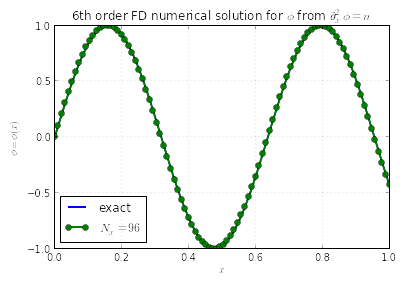

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

error_norm, x, phi, phi_exact = Poisson_6th(Nx = 96, return_all_results = 'yes')

plt.plot(x, phi_exact, label = 'exact', linewidth = 2)
plt.hold('on')
plt.plot(x, phi, label = '$N_x = 96$', marker = 'o', linewidth = 2)
plt.hold('off')

plt.xlabel('$x$')
plt.ylabel(r'$\phi = \phi (x)$')
plt.title('6th order FD numerical solution for $\phi$ from $\partial_x^2\phi = n$')

plt.legend(loc = 'best')
plt.grid('on')

# F. Solvers for different boundary conditions (constant background $n_0$)

## F.1 Periodic boundary conditions (PBCs)

We consider the problem:

$$\partial_x^2\phi = n_e - n_i, \quad x\in [a,b]\subset \mathbb{R}\times\mathbb{R}$$

the numerical solution can be modeled as a matrix problem similar to in section C.

$$\underline{\underline{D}}\underline{\phi} = \underline{b}$$

where $\underline{\phi} = (\phi_0, \phi_1, \ldots , \phi_{N - 1})$, and the $N$ gridpoints $x_i$ constitute the mesh $\mathcal{M}_h = \{\cup_i x_i \,\colon \, x_i\in [a,b]\, \forall i \in \mathbb{Z}\}$ in our 0-base indexing. Given the periodicity, the differences equation $(*)$:

$$\frac{1}{(\Delta x)^2}\left(\phi_{i+1} - 2\phi_i + \phi_{i-1}\right) = n_i + \frac{2}{4!}(\Delta x)^2n_{e,i}^{(2)} + \frac{2}{6!}(\Delta x)^4n_{e,i}^{(4)} + O(\Delta x^6) \qquad \qquad (\, * \, )$$

can be applied for all nodal equations $i$ since off-grid quantities ($\phi_{-1}, \phi_N$) are related to on-grid data in a known way. Thus, in the above we do not require "edge" versions of finite differences to sidestep off-grid terms in our finite differencing, even for the right-hand side in differencing the density $n$. <b>That is to say, the interior nodes differencing equation at the conclusion of section C.2.2 can be used for all nodes in the domain in the periodic case</b> 

The aforementioned differenced equation from sction C.2.2 is:

$$\frac{1}{(\Delta x)^2}\left(\phi_{i+1} - 2\phi_i + \phi_{i-1}\right) = -n_0 - \frac{1}{240}n_{e,i-2} + \frac{1}{10}n_{e,i-1} + \frac{97}{120}n_{e,i} + \frac{1}{10}n_{e,i+1} - \frac{1}{240}n_{e,i+2} + O(\Delta x^6), \quad i = 0, 1, \ldots , N - 1$$

For a grid $i = 0, 1, \ldots , N-1$ ($N$ gridpoints) we understand we require only updating one of the endpoints (say, $i = 0$), the other endpoint is completed at each time step by periodic enforcement (at $i = N-1$). 

\begin{eqnarray*}
\phi_{N-1} & = & \phi_0\\
\text{and} &&\\
n_{N-1} & = & n_0
\end{eqnarray*}

Similarly,

\begin{eqnarray*}
\phi_{-1} & = & \phi_{N-2}\\
\phi_{N} & = & \phi_1\\
&& \\
n_{-2} & = & n_{N-3} \\
n_{-1} & = & n_{N-2} \\
n_N & = & n_1 \\
n_{N+1} & = & n_2 
\end{eqnarray*}

To clearly discern the forms of the matrices above, we write equations for several gridpoints. We omit the multiplicative prefactor $(\Delta x)^{-2}$ on the left-hand side and incorporate it in the end.

\begin{eqnarray*}
i = 0: & \phi_1 - 2\phi_0 + \phi_{N-2} & = -n_0 - \frac{1}{240}n_{e,N-3} + \frac{1}{10}n_{e,N-2} + \frac{97}{120}n_{e,0} + \frac{1}{10}n_{e,1} - \frac{1}{240}n_{e,2}  \\[1em]
i = 1: & \phi_0 -2\phi_1 + \phi_2 & = -n_0 - \frac{1}{240}n_{e,N-2} + \frac{1}{10}n_{e,0} + \frac{97}{120}n_{e,1} + \frac{1}{10}n_{e,2} - \frac{1}{240}n_{e,3}  \\[1em]
i = 2: & \phi_1 -2\phi_2 + \phi_3 & = -n_0 - \frac{1}{240}n_{e,0} + \frac{1}{10}n_{e,1} + \frac{97}{120}n_{e,2} + \frac{1}{10}n_{e,3} - \frac{1}{240}n_{e,4} \\[1em]
i = 3: & \phi_2 -2\phi_3 + \phi_4 & = -n_0 - \frac{1}{240}n_{e,1} + \frac{1}{10}n_{e,2} + \frac{97}{120}n_{e,3} + \frac{1}{10}n_{e,4} - \frac{1}{240}n_{e,5} \\[2em]
\vdots \\[2em]
i = N-4: & \phi_{N-5} -2\phi_{N-4} + \phi_{N-3} & = -n_0 - \frac{1}{240}n_{e,N-6} + \frac{1}{10}n_{e,N-5} + \frac{97}{120}n_{e,N-4} + \frac{1}{10}n_{e,N-3} - \frac{1}{240}n_{e,N-2} \\[1em]
i = N-3: & \phi_{N-4} -2\phi_{N-3} + \phi_{N-2} & = -n_0 - \frac{1}{240}n_{e,N-5} + \frac{1}{10}n_{e,N-4} + \frac{97}{120}n_{e,N-3} + \frac{1}{10}n_{e,N-2} - \frac{1}{240}n_{e,0} \\[1em]
i = N - 2: & \phi_{N-3} - 2\phi_{N-2} + \phi_{0} & = -n_0 - \frac{1}{240}n_{e,N-4} + \frac{1}{10}n_{e,N-3} + \frac{97}{120}n_{e,N-2} + \frac{1}{10}n_{e,0} - \frac{1}{240}n_{e,1}
\end{eqnarray*}

The left-hand side reveals $\underline{\underline{D}}$:

$$\underline{\underline{D}}_{(N-1)\times (N-1)} = \left( \begin{array}{c c c c c c c c c}
-2 & 1 & 0 & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & 1 \\
1 & -2 & 1 & 0 & \cdots & \cdots & \cdots & \cdots  & \cdots & 0 \\
0 & 1 & -2 & 1 & 0 & \cdots & \cdots & \cdots &  \cdots & 0 \\
0 & 0 & 1 & -2 & 1 & 0 & \cdots & \cdots & \cdots & 0\\
\vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & \cdots & \cdots & 0\\
\vdots & \vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & \cdots & 0\\
\vdots & \vdots & \vdots & \vdots & 0 & \ddots & \ddots & \ddots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & 0 & 1 & -2 & 1 & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & 0 & 1 & -2 & 1 \\
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & -2
\end{array} \right)$$

which is a <i>circulant</i> matrix, whose eigenvalues $\lambda_j$ ($j = 0, 1, \ldots , N-2 $) are given by:

$$\lambda_j = c_0 + c_{N-2}\omega_j + c_{N-3}\omega_j^2 + \ldots + c_1\omega_j^{N-2}$$

where $\omega_j = \exp (2\pi i j / (N-1) )$ is the $j$th root of unity and

$$c_j = \begin{cases}
-2 & j = 0\\
&\\
1 & j = N-2, 1\\
& \\
0 & \text{else}
\end{cases}
$$

so that the eigenvalues are 

$$\lambda_j = -2 + \omega_j + \omega_j^{N-2} = -2 + \exp \left(\frac{2\pi i j}{N-1}\right) + \exp \left(2\pi i j\frac{N - 2}{N - 1}\right)$$

Thus, zero is an eigenvalue ($j = 0$) and the matrix is not invertible, so there are infinitely many solutions to the equation and the solution must be solved through means that do not involve finding an explicit inverse of the matrix. The right-hand side can be casted similar to before:

$$\underline{b}_{(N-1)\times 1} = \underline{\underline{B}}_{e,(N-1)\times (N-1)}\underline{n}_{e,(N-1)\times 1} - \underline{n}_{0,(N-1)\times 1}, \qquad \underline{n}_0 = \underline{1}_{(N-1)\times 1}n_0$$

then

$$\underline{\underline{B}}_{e,(N-1)\times (N-1)} = \left( \begin{array}{c c c c c c c c c c c c c c}
\frac{97}{120} & \frac{1}{10} & -\frac{1}{240} & 0 &  0 &  0 &    \cdots &  0 & -\frac{1}{240} & \frac{1}{10}\\
\frac{1}{10} & \frac{97}{120} & \frac{1}{10} & 0 & \cdots  & \cdots & \cdots & \cdots & 0 & -\frac{1}{240}\\
-\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} & 0 & \cdots & \cdots & \cdots & 0 \\
0 & -\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} & 0 & \cdots & \cdots & 0 \\
\vdots & 0 & \ddots & \ddots & \ddots & \ddots & \ddots & 0 & \cdots & 0 \\
\vdots  & \vdots  & 0 & \ddots & \ddots & \ddots & \ddots & \ddots & 0 & 0\\
\vdots & \vdots & \vdots & 0 & \ddots & \ddots & \ddots & \ddots & \ddots & 0\\
0 & \vdots & \vdots & \vdots &  0 &  -\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} & -\frac{1}{240} \\
-\frac{1}{240} & \vdots & \vdots & \vdots & \vdots & 0 & -\frac{1}{240} & \frac{1}{10} & \frac{97}{120} & \frac{1}{10} \\
\frac{1}{10} & -\frac{1}{240} & 0 & 0 &  0  & 0 & 0 &  -\frac{1}{240} &  \frac{1}{10} &  \frac{97}{120}  \\
\end{array} \right)$$

So, Poisson's equation for a constant background density $n_0$ and an evolved density $n_e$ for electrons is solved numerically according to the matrix equation in terms of the $N-1$ unknowns $i = 0, 1, \ldots , N-2$:

$$\underline{\underline{D}}_{(N-1)\times (N-1)} \underline{\phi}_{(N-1)\times 1} = (\Delta x)^2\underline{\underline{B}}_{e,(N-1)\times (N-1)}\cdot \underline{n}_e - (\Delta x)^2\underline{n_0}$$

and then enforcing

$$\phi_{N-1} = \phi_0$$

per periodic boundary condition to complete the solution vector for all $N$ gridpoints.

## F.1.1 Solubility conditions for PBCs

Poisson's equation subject to periodic boundary conditions (PBCs) has the form

$$\partial_x^2\phi = n, \qquad x\in [a, b], \quad \phi (a) = \phi (b)$$

Integrating this equation once we recover

$$\partial_x\phi (b) - \partial_x\phi (a) = \int_a^b dx n = = (b-a)\langle n \rangle$$

    

## F.1.2 Convergence test

For the trial density: 

$$n_e - n_0 \equiv n = -4\pi^2 \sin (2\pi x), \quad x\in [0, 1]$$

with boundary condition:

$$\phi (0) = \phi (1)$$

the exact solution per $\partial_x^2\phi = n$, is found as

\begin{eqnarray*}
\int dx \frac{\partial^2 \phi}{\partial x^2} & = & -\int dx \pi^2 \sin (2\pi x)   \\
&&\\
\partial_x\phi & = & 2\pi\cos (2\pi x) + C 
\end{eqnarray*}

so

\begin{eqnarray*}
\int dx \frac{\partial\phi}{\partial x} & = & \int dx \left( 2\pi\cos (2\pi x) + C\right) \\
\phi (x) & = & \sin (2 \pi x) + Cx + D \\
\end{eqnarray*}

Applying the boundary condition:

$$\phi (0) = D$$

and

$$\phi (1) = C + D$$

we have $\phi (0) = \phi (1)$ or $D = C + D \Rightarrow 0 = C$, thus $C = 0$. Thus, we have

$$\phi (x) = \sin (2\pi x) + D$$

where $D\in\mathbb{R}$ admits parameter family of solutions for any $D$. In this situation, we know since $\langle n \rangle = 0$, that $\langle \phi \rangle = 0$, i.e. $\langle \phi\rangle = \langle\sin (2\pi x) + D\rangle = 0 + D$, thus $D = 0$, so the final solution is:

$$\phi (x) = \sin (2\pi x)$$

This is also the situation in plasmas that we aim to simulate (quasineutrality). We use the above solver to see if the Poisson problem for the above density and periodic BCs can reproduce this solution adequately to the designed convergence rate (order 6).

## F.1.2 PBC 6th order Poisson solver code

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA

def Poisson_PBC_6th(Nx = 24, a = 0, b = 1, return_all_results = 'no'):
    """6th order LTE finite difference Poisson solver for Dirichlet BCs

    inputs:
    Nx -- (int) number of grid points
    a -- (float) left boundary of x-domain
    b -- (float) right boundary of x-domain
    return_all_results -- (str) if 'yes', function returns ( x, phi, phi_exact, error)
                          elif 'no', function returns (error)
                          
    outputs:
    error -- (float) L2 norm
    x -- (ndarray, ndim = 1) mesh points (abscissa)
    phi -- (ndarray, ndim = 1) numerical solution to potential
    phi_exact -- (ndarray, ndim = 1) exact solution (chosen)
    """
    # mesh setup
    a = float(a)
    b = float(b)
    L = b - a
    x = np.linspace(a, b, Nx) # spacing dx = (b - a ) / (Nx - 1)
    dx = L / (Nx - 1)
    
    # phi_exact is chosen, Poisson's equation gives n
    n = -4*np.pi**2 * np.sin(2*np.pi * x[:Nx-1]) # excepting right endpoint, since n[Nx-1] = n[0]
    print n.shape
    phi_exact = np.sin(2*np.pi*x) # over all x
    
    # form the tensor objects involved in the numerical solution
    #
    #     d^2 phi = n --> D*phi = B*n + phi_BC

    
    # Assemble FD coefficient matrix on phi: D
    D = np.zeros([Nx-1,Nx-1])
    for i in range(Nx-1):
        if i == 0:
            D[i,i] = -2
            D[i,i+1] = 1
            D[i,Nx-2] = 1
            
        elif i == Nx-2:
            D[i,i] = -2
            D[i,i-1] = 1
            D[i,0] = 1
        else:
            D[i,i-1] = 1
            D[i,i] = -2
            D[i,i+1] = 1

    # Assemble FD coefficient matrix on n: B
    B = np.zeros([Nx-1,Nx-1])
    for i in range(Nx-1):
        if i == 0:
            B[i,Nx-3] = -1/240.
            B[i,Nx-2] = 1/10.
            B[i,i] = 97/120.
            B[i,i+1] = 1/10.
            B[i,i+2] = -1/240.

        elif i == 1:
            B[i,Nx-2] = -1/240.
            B[i,i-1] = 1/10.
            B[i,i] = 97/120.
            B[i,i+1] = 1/10.
            B[i,i+2] = -1/240.

        elif 1 < i < Nx-3:
            B[i,i-2] = -1/240.
            B[i,i-1] = 1/10.
            B[i,i] = 97/120.
            B[i,i+1] = 1/10.
            B[i,i+2] = -1/240.

        elif i == Nx-3:
            B[i,i-2] = -1/240.
            B[i,i-1] = 1/10.
            B[i,i] = 97/120.
            B[i,i+1] = 1/10.
            B[i,0] = -1/240.

        elif i == Nx-2:
            B[i,i-2] = -1/240.
            B[i,i-1] = 1/10.
            B[i,i] = 97/120.
            B[i,0] = 1/10.
            B[i,1] = -1/240.

    print B.shape
    # label the RHS a b = dx ** 2 * B*n
    b = dx ** 2 * B.dot(n)

    # solve D*phi = b
    phi = LA.solve(D,b)
    
    phi_total = np.zeros(Nx)
    phi_total[:Nx-1] = phi
    
    # periodic BC
    phi_total[Nx-1] = phi[0]
    # define normalized root-mean square error, i.e. normalized L2 norm of the error
    error_norm = LA.norm(phi_exact - phi_total,2) * np.sqrt(dx / L)
    
    if return_all_results.lower() != 'no':
        return error_norm, x, phi_total, phi_exact
    else:
        return error_norm

(511,)
(511, 511)
0.199795551829
0.199795551829


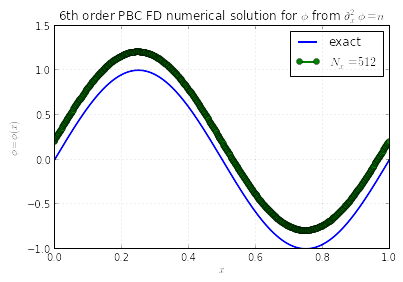

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Nx = 512
error_norm, x, phi, phi_exact = Poisson_PBC_6th(Nx, return_all_results = 'yes')
print phi[0]
print phi[-1]
plt.plot(x, phi_exact, label = 'exact', linewidth = 2)
plt.hold('on')
plt.plot(x, phi, label = '$N_x = %d$' % Nx, marker = 'o', linewidth = 2)
plt.hold('off')

plt.xlabel('$x$')
plt.ylabel(r'$\phi = \phi (x)$')
plt.title('6th order PBC FD numerical solution for $\phi$ from $\partial_x^2\phi = n$')

plt.legend(loc = 'best')
plt.grid('on')

Thus, the solve produces a periodic potential correct up to an additive constant. This is expected $\lambda = 0$ is an eigenvalue and the solution expressed in terms of its eigenbasis necessarily has an offset term whose value is not uniquely enforced in the above through any boundary value, rather this value is only maintained to be equal to that of the other endpoint one period away from the other.

## F.1.3 Periodic conditions on the Dirichlet formulation: $\phi (a) = \phi (b) = \text{arbitrary}$

Here, we set the potential to be $\phi (0) = \phi (1) = 0$. If we wanted to match the FD solution just above we could enforce $\phi (0) = \phi (1) = 0.2$. We re-define the Dirichlet form just below to establish the same density as used above, and test the result:

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA

def Poisson_6th(Nx = 24, a = 0, b = 1, return_all_results = 'no'):
    """6th order LTE finite difference Poisson solver for Dirichlet BCs

    inputs:
    Nx -- (int) number of grid points
    a -- (float) left boundary of x-domain
    b -- (float) right boundary of x-domain
    return_all_results -- (str) if 'yes', function returns ( x, phi, phi_exact, error)
                          elif 'no', function returns (error)
                          
    outputs:
    error -- (float) L2 norm
    x -- (ndarray, ndim = 1) mesh points (abscissa)
    phi -- (ndarray, ndim = 1) numerical solution to potential
    phi_exact -- (ndarray, ndim = 1) exact solution (chosen)
    """
    # mesh setup
    a = float(a)
    b = float(b)
    L = b - a
    x = np.linspace(a, b, Nx) # spacing dx = (b - a ) / (Nx - 1)
    dx = L / (Nx - 1)
    
    # phi_exact is chosen, Poisson's equation gives n
    n = -4*np.pi**2 * np.sin(2*np.pi * x) # excepting right endpoint, since n[Nx-1] = n[0]
    phi_exact = np.sin(2*np.pi*x) # over all x
    
    # the boundary values are periodic, the actual values are arbitrary
    phi_a = 0
    phi_b = 0
    
    # form the tensor objects involved in the numerical solution
    #
    #     d^2 phi = n --> D*phi = B*n + phi_BC

    

    # Assemble FD coefficient matrix on phi: D
    D = np.zeros([Nx,Nx])
    for i in range(Nx):
        if i == 0 or i == Nx-1:
            D[i,i] = 1
        else:
            D[i,i-1] = 1
            D[i,i] = -2
            D[i,i+1] = 1

    # Assemble FD coefficient matrix on n: B
    B = np.zeros([Nx,Nx])
    for i in range(Nx):
        if i == 0:
            B[i,i] = 0

        elif i == 1:
            B[i,i-1] = 3/40.
            B[i,i] = 209/240.
            B[i,i+1] = 1/60.
            B[i,i+2] = 7/120.
            B[i,i+3] = -1/40.
            B[i,i+4] = 1/240.

        elif i == Nx-1:
            B[i,i] = 0

        elif 1 < i < Nx-2:
            B[i,i-2] = -1/240.
            B[i,i-1] = 1/10.
            B[i,i] = 97/120.
            B[i,i+1] = 1/10.
            B[i,i+2] = -1/240.

        elif i == Nx-2:
            B[i,i-4] = 1/240.
            B[i,i-3] = -1/40.
            B[i,i-2] = 7/120.
            B[i,i-1] = 1/60.
            B[i,i] = 209/240.
            B[i,i+1] = 3/40.

    print B.shape
    print n.shape
    # Dirichlet boundary conditions (DBC) vector
    phi_DBC = np.zeros(Nx)
    phi_DBC[0] = phi_a
    phi_DBC[-1] = phi_b

    # label the RHS a b = dx ** 2 * B*n + phi_DBC
    b = dx ** 2 * B.dot(n) + phi_DBC

    # solve D*phi = b
    phi = LA.solve(D,b)
    
    # define normalized root-mean square error, i.e. normalized L2 norm of the error
    error_norm = LA.norm(phi_exact - phi,2) * np.sqrt(dx / L)

    if return_all_results.lower() != 'no':
        return error_norm, x, phi, phi_exact
    else:
        return error_norm

(512, 512)
(512,)


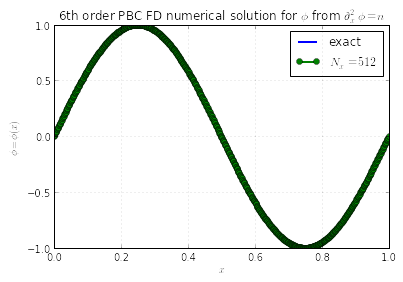

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Nx = 512
error_norm, x, phi, phi_exact = Poisson_6th(Nx, return_all_results = 'yes')

plt.plot(x, phi_exact, label = 'exact', linewidth = 2)
plt.hold('on')
plt.plot(x, phi, label = '$N_x = %d$' % Nx, marker = 'o', linewidth = 2)
plt.hold('off')

plt.xlabel('$x$')
plt.ylabel(r'$\phi = \phi (x)$')
plt.title('6th order PBC FD numerical solution for $\phi$ from $\partial_x^2\phi = n$')

plt.legend(loc = 'best')
plt.grid('on')

# G. Conclusions and prospects

<i><u>Conclusions</u></i>: A finite difference solver for Poisson's equation ($\partial_x^2 \phi = n$) was developed. The scheme increases the LTE order of the second derivative on $\phi$ by replacing the higher order derivatives of $\phi$ that appear (in formerly truncated terms) with lower order, and differenced, derivatives of the density $n$ by resusing the original PDE. The case for Dirichlet boundary conditions were considered and an implementation was designed for both a cold ion (constant) background density $n_i$ alongside the evolving electron density $n_e$ (i.e. $n = n_e - n_i$, the "minus" sign in Poisson's equation is already accounted for here).

<i><u>Prospects</u></i>: To manage Neumann (and, hence Robin) boundary conditions. The stepthrough remains obvious, yet the details just require working through. For example, a Neumann boundary condition:

$$\partial_x\phi|_{x = a} = \partial_x\phi_a$$

can be incorporated by differencing the above equation,

$$\text{naive idea: } \qquad \frac{\phi_1 - \phi_0}{\Delta x} = \partial_x\phi_a + O(\Delta x)$$

for a first order estimate. This will tarnish the accuracy of the 6th order scheme, thus it is desirable to devise a means to difference at the edge accurately. 

$$\text{requirement: } \qquad \delta_x \phi_0 = \partial_x\phi_a + O(\Delta x^6)$$

where as usual, $\delta_x$ is a finite difference operator compared to the continuous analog $\partial_x$.We recall the notoriety of edge differencing from <a href = "../DECSKS-03%20--%20Convergence%20of%20FD%20formulation%20of%20high%20order%20CS/DECSKS-03%20--Convergence%20of%20FD%20formulation%20of%20high%20order%20CS.ipynb">previous experience</a>, hence we require more care in order to have a differencing perform up to the required LTE order of 6. Hence, for lack of immedite desire and context in current test problems we save this work for later. It is noted that Neumann boundary conditions are most popularly dealt with by considering half-interger grid points at the boundary, e.g. $x_{-1/2}$ and $x_{1/2}$ in attempts to inherit the accuracy of central schemes as compared to deviations from central grid sampling. This requires knowledge of the function itself outside of the domain. We close by noting fitting a polynomial may suffice, and will be looked into at a future time when motivation to do so meets required needs.